In [ ]:
import os
import zipfile
from google.colab import files

# Step 1: Upload `kaggle.json`
if not os.path.exists("~/.kaggle/kaggle.json"):
    print("Please upload your kaggle.json file.")
    uploaded = files.upload()  # User uploads kaggle.json file
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    with open("kaggle.json", "wb") as f:
        f.write(uploaded["kaggle.json"])
    os.rename("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

# Step 2: Download the UTKFace Dataset
!pip install -q kaggle
dataset_name = "jangedoo/utkface-new"
output_path = "utkface-new.zip"

if not os.path.exists(output_path):
    print(f"Downloading {dataset_name} dataset...")
    os.system(f"kaggle datasets download -d {dataset_name} -p ./")
    print("Dataset downloaded!")

dataset_dir = "./UTKFace"

if not os.path.exists(dataset_dir):
    print("Extracting dataset...")
    with zipfile.ZipFile(output_path, "r") as zip_ref:
        zip_ref.extractall(dataset_dir)
    print(f"Dataset extracted to {dataset_dir}!")
else:
    print("Dataset already extracted.")

print("Sample files in the dataset directory:")
print(os.listdir(dataset_dir)[:10])  # Show the first 10 files

Please upload your kaggle.json file.


Saving kaggle.json to kaggle.json
Dataset downloaded!
Extracting dataset...
Dataset extracted to ./UTKFace!
Sample files in the dataset directory:
['UTKFace', 'utkface_aligned_cropped', 'crop_part1']


In [ ]:
import os
import pandas as pd

image_dir = './UTKFace/'
data = []

def process_images_in_directory(image_dir):
    for root, dirs, files in os.walk(image_dir):
        for file_name in files:
            try:
                if file_name.endswith('.jpg'):
                    parts = file_name.split('_')

                    # Check that the filename follows the format: age_gender_race.jpg
                    if len(parts) == 4:
                        age, gender, race = map(int, parts[:3])
                        file_path = os.path.join(root, file_name)
                        data.append((file_path, age, gender, race))
            except ValueError:
                print(f"Skipping file {file_name} due to incorrect format.")

process_images_in_directory(image_dir)

df = pd.DataFrame(data, columns=["file_path", "age", "gender", "race"])
print(df.head())  # Display first few rows of the DataFrame



                                           file_path  age  gender  race
0  ./UTKFace/UTKFace/23_1_3_20170119164552438.jpg...   23       1     3
1  ./UTKFace/UTKFace/27_0_1_20170117125937977.jpg...   27       0     1
2  ./UTKFace/UTKFace/26_1_2_20170116184050204.jpg...   26       1     2
3  ./UTKFace/UTKFace/22_1_3_20170104222547654.jpg...   22       1     3
4  ./UTKFace/UTKFace/28_0_2_20170116191850216.jpg...   28       0     2


In [ ]:
from tensorflow.keras.utils import img_to_array, load_img
import numpy as np

def preprocess_image(img_path, target_size=(128, 128)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    return img_array

df['image'] = df['file_path'].apply(preprocess_image)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1.0/255)  # Normalize pixel values

batch_size = 32
img_size = (128, 128)

data_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='file_path',
    y_col=['age', 'gender', 'race'],  # Multi-output
    target_size=img_size,
    batch_size=batch_size,
    class_mode='multi_output',
    shuffle=True
)


Found 66966 validated image filenames.


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")



Training samples: 53572, Validation samples: 13394


In [ ]:

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col=['age', 'gender', 'race'],
    target_size=img_size,
    batch_size=batch_size,
    class_mode='multi_output',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col=['age', 'gender', 'race'],
    target_size=img_size,
    batch_size=batch_size,
    class_mode='multi_output',
    shuffle=False
)


Found 53572 validated image filenames.
Found 13394 validated image filenames.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (128, 128, 3)

inputs = tf.keras.Input(shape=input_shape)

x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)

age_output = layers.Dense(1, name='age')(x)

gender_output = layers.Dense(1, activation='sigmoid', name='gender')(x)

race_output = layers.Dense(5, activation='softmax', name='race')(x)

model = models.Model(inputs=inputs, outputs=[age_output, gender_output, race_output])

model.compile(
    optimizer='adam',
    loss={
        'age': 'mse',             # Mean squared error for age regression
        'gender': 'binary_crossentropy',  # Binary cross-entropy for gender
        'race': 'sparse_categorical_crossentropy'  # Sparse categorical cross-entropy for race
    },
    metrics={
        'age': 'mae',  # Mean absolute error for age
        'gender': 'accuracy',  # Accuracy for gender
        'race': 'accuracy'  # Accuracy for race
    }
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 63, 63, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 57600)          │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age (Dense)               │ (None, 1)              │         57,601 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender (Dense)            │ (None, 1)              │         57,601 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ race (Dense)              │ (None, 5)              │        288,005 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 422,599 (1.61 MB)

 Trainable params: 422,599 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

file_paths = train_df['file_path'].values
age_labels = train_df['age'].values
gender_labels = train_df['gender'].values
race_labels = train_df['race'].values


In [ ]:
import tensorflow as tf

def load_and_preprocess_image(file_path, age, gender, race):

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (128, 128))
    img = img / 255.0  # Normalize pixel values
    return img, {'age': age, 'gender': gender, 'race': race}

train_dataset = tf.data.Dataset.from_tensor_slices((file_paths, age_labels, gender_labels, race_labels))
train_dataset = train_dataset.map(load_and_preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_file_paths = val_df['file_path'].values
val_age_labels = val_df['age'].values
val_gender_labels = val_df['gender'].values
val_race_labels = val_df['race'].values

val_dataset = tf.data.Dataset.from_tensor_slices((val_file_paths, val_age_labels, val_gender_labels, val_race_labels))
val_dataset = val_dataset.map(load_and_preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=len(train_df) // batch_size,
    validation_steps=len(val_df) // batch_size
)


Epoch 1/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - age_loss: 340.6252 - age_mae: 14.0904 - gender_accuracy: 0.7518 - gender_loss: 0.5578 - loss: 342.7038 - race_accuracy: 0.5685 - race_loss: 1.5207 - val_age_loss: 268.7579 - val_age_mae: 12.7422 - val_gender_accuracy: 0.8352 - val_gender_loss: 0.4325 - val_loss: 270.0275 - val_race_accuracy: 0.7685 - val_race_loss: 0.8369
Epoch 2/10
   1/1674 ━━━━━━━━━━━━━━━━━━━━ 59:30 2s/step - age_loss: 288.4777 - age_mae: 11.7368 - gender_accuracy: 1.0000 - gender_loss: 0.0643 - loss: 289.4170 - race_accuracy: 0.7500 - race_loss: 0.8751

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1674/1674 ━━━━━━━━━━━━━━━━━━━━ 3s 580us/step - age_loss: 288.4777 - age_mae: 11.7368 - gender_accuracy: 1.0000 - gender_loss: 0.0643 - loss: 289.4170 - race_accuracy: 0.7500 - race_loss: 0.8751 - val_age_loss: 413.1298 - val_age_mae: 16.1784 - val_gender_accuracy: 0.8333 - val_gender_loss: 0.5315 - val_loss: 414.1148 - val_race_accuracy: 0.8333 - val_race_loss: 0.4535
Epoch 3/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 74s 21ms/step - age_loss: 158.0953 - age_mae: 9.6694 - gender_accuracy: 0.8555 - gender_loss: 0.3597 - loss: 159.4168 - race_accuracy: 0.7431 - race_loss: 0.9617 - val_age_loss: 243.0364 - val_age_mae: 12.4377 - val_gender_accuracy: 0.8660 - val_gender_loss: 0.3310 - val_loss: 244.1936 - val_race_accuracy: 0.7769 - val_race_loss: 0.8264
Epoch 4/10
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - age_loss: 292.8481 - age_mae: 12.0475 - gender_accuracy: 1.0000 - gender_loss: 0.0469 - loss: 292.9201 - race_accuracy: 1.0000 - race_loss: 0.0252 - val_age_loss: 361.1200 - val_age_mae: 14.6

In [ ]:

val_loss, val_age_loss, val_gender_loss, val_race_loss, val_age_mae, val_gender_acc, val_race_acc = model.evaluate(val_dataset)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Age Loss (MSE): {val_age_loss:.4f}")
print(f"Validation Gender Accuracy: {val_gender_acc:.4f}")
print(f"Validation Race Accuracy: {val_race_acc:.4f}")


419/419 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - age_loss: 115.2839 - age_mae: 8.2426 - gender_accuracy: 0.9326 - gender_loss: 0.1883 - loss: 116.0379 - race_accuracy: 0.8677 - race_loss: 0.5660
Validation Loss: 114.0302
Validation Age Loss (MSE): 113.3046
Validation Gender Accuracy: 0.9294
Validation Race Accuracy: 0.8676


In [ ]:
print(history.history.keys())


dict_keys(['age_loss', 'age_mae', 'gender_accuracy', 'gender_loss', 'loss', 'race_accuracy', 'race_loss', 'val_age_loss', 'val_age_mae', 'val_gender_accuracy', 'val_gender_loss', 'val_loss', 'val_race_accuracy', 'val_race_loss'])


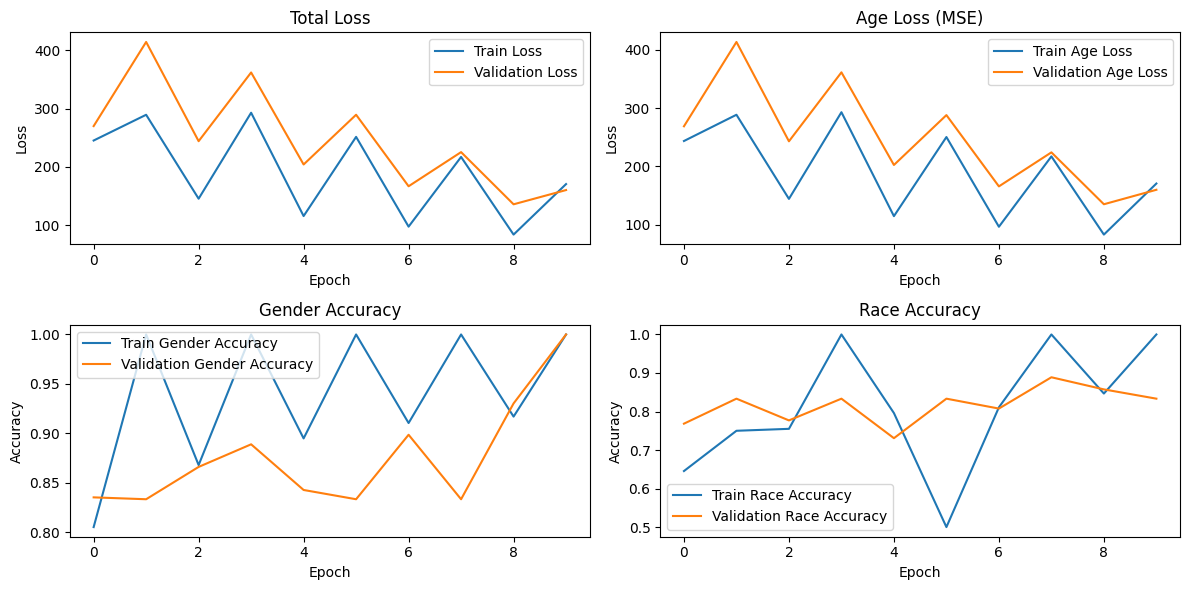

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Age Loss (MSE)
plt.subplot(2, 2, 2)
plt.plot(history.history['age_loss'], label='Train Age Loss')
plt.plot(history.history['val_age_loss'], label='Validation Age Loss')
plt.title('Age Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Gender Accuracy
plt.subplot(2, 2, 3)
plt.plot(history.history['gender_accuracy'], label='Train Gender Accuracy')
plt.plot(history.history['val_gender_accuracy'], label='Validation Gender Accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Race Accuracy
plt.subplot(2, 2, 4)
plt.plot(history.history['race_accuracy'], label='Train Race Accuracy')
plt.plot(history.history['val_race_accuracy'], label='Validation Race Accuracy')
plt.title('Race Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:

model.save('age_gender_race_model.h5')



In [ ]:
# Load a sample image and preprocess it
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/UTKFace/crop_part1/100_1_2_20170105174847679.jpg.chip.jpg'
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)

predicted_age = predictions[0][0]
predicted_gender = predictions[1][0]
predicted_race = predictions[2][0]

print(f"Predicted Age: {predicted_age}")
print(f"Predicted Gender: {'Male' if predicted_gender < 0.5 else 'Female'}")
print(f"Predicted Race: {predicted_race}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Age: [52.79395]
Predicted Gender: Female
Predicted Race: [2.1158166e-05 8.5734925e-04 9.9448907e-01 1.7705290e-05 4.6148002e-03]


In [ ]:
from google.colab import files
files.download('age_gender_race_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
model = load_model('age_gender_race_model.h5', compile=False)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

def predict(img):
    try:

        if img.mode != "RGB":
            img = img.convert("RGB")

        img = img.resize((128, 128))

        img_array = img_to_array(img) / 255.0

        img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 128, 128, 3)

        predictions = model.predict(img_array)

        age = predictions[0][0]
        gender = "Male" if predictions[1][0] < 0.5 else "Female"
        race_idx = np.argmax(predictions[2])  # Index of the race with the highest probability

        race_mapping = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Other"}
        race = race_mapping.get(race_idx, "Unknown")

        return f"Predicted Age: {float(age):.2f}\nGender: {gender}\nRace: {race}"

    except Exception as e:
        return f"An error occurred: {str(e)}"

interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Age, Gender, and Race Prediction",
    description="Upload an image to predict age, gender, and race."
)

interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4c1fd96145d5937a57.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
